In [1]:
# TODO: Use this to profile: https://stackoverflow.com/questions/45893768/how-do-i-find-out-what-parts-of-my-code-are-inefficient-in-python
%load_ext line_profiler

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import holidays
import dataclasses
import datetime
import pprint

from datetime import timedelta
from enum import Enum, auto
from typing import List, Optional
from pandas.tseries.offsets import BDay

pp = pprint.PrettyPrinter(indent=4)

In [3]:
API_KEY = 'cfg2wsKZrVNuYBJpETAs'
DEVELOPMENT = False

if DEVELOPMENT:
    daily_metrics = pd.read_csv('SHARADAR-DAILY.csv')
    daily_prices = pd.read_csv('SHARADAR-SEP.csv')
else:
    daily_metrics = pd.read_csv('SHARADAR_DAILY_3_9ffd00fad4f19bbdec75c6e670d3df83.csv')
    daily_prices = pd.read_csv('SHARADAR_SEP_2_0bd2000858d1d8d1f48d4cdea5f8c9e2.csv')

In [4]:
d1 = daily_metrics.copy()

d2 = daily_prices[['ticker', 'date','closeadj']]
d2.rename(columns={'closeadj': 'price'}, inplace=True)

daily_data = d1.merge(d2, on=['date', 'ticker'], how='inner')
daily_data

/Users/olshansky/.pyenv/versions/3.7.7/envs/tip_env/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,ticker,date,lastupdated,ev,evebit,evebitda,marketcap,pb,pe,ps,price
0,A,2020-12-18,2020-12-18,37525.1,40.8,30.6,36607.1,7.5,50.9,6.9,118.928
1,AA,2020-12-18,2020-12-18,4896.3,-43.0,8.9,4092.3,1.2,-8.7,0.4,22.010
2,AACQ,2020-12-18,2020-12-18,943.3,NaN,NaN,944.6,188.9,NaN,NaN,10.430
3,AAIC,2020-12-18,2020-12-18,817.6,-15.8,-15.8,125.0,0.5,-2.3,5.3,3.740
4,AAIIQ,2020-12-18,2020-12-18,-2.8,0.5,0.8,0.4,0.0,-0.1,0.0,0.100
...,...,...,...,...,...,...,...,...,...,...,...
14551055,GSTCQ,2011-01-04,2021-05-30,235.6,3.4,3.0,218.6,1.4,-575.3,5.0,4.340
14551056,MHRCQ,2011-01-04,2021-05-30,471.6,-29.7,-64.3,419.2,6.0,-19.3,13.6,7.230
14551057,EPRSQ,2011-01-03,2021-05-30,153.1,187.2,8.6,155.8,2.1,74.4,2.9,105.000
14551058,GSTCQ,2011-01-03,2021-05-30,242.7,3.5,3.1,225.7,1.4,-593.9,5.1,4.480


In [19]:
class StockUniverse(Enum):
    SMALL = auto()  # < $1B
    MID = auto()  # $1B - $10B
    LARGE = auto()  # > $100B
    
class EvaluationMetric(Enum):
    EV_EBIT = auto()
    P_E = auto()
    P_B = auto()
    DIV_YIELD = auto()

    def __str__(self):
        if self.value == EvaluationMetric.EV_EBIT.value:
            return 'EV/EBIT'
        elif self.value == EvaluationMetric.P_E.value:
            return 'P/E'
        elif self.value == EvaluationMetric.P_B.value:
            return 'P/B'
        elif self.value == EvaluationMetric.DIV_YIELD.value:
            return '% Div Yield'
        else:
            raise Exception(f'Unsupported evaluation metric {metric}')
    
def get_closest_previous_work_day(
    check_day: datetime.datetime,
    holidays=holidays.US()
) -> datetime.datetime:
    if check_day.weekday() <= 4 and check_day not in holidays:
        return check_day
    offset = max(1, (check_day.weekday() + 6) % 7 - 3)
    most_recent = check_day - datetime.timedelta(offset)
    if most_recent not in holidays:
        return most_recent
    else:
        return get_closest_previous_work_day(most_recent, holidays)

def get_rebalance_dates(
    start_date: datetime.datetime,
    end_date: datetime.datetime,
    period_length: datetime.timedelta
) -> List[datetime.datetime]:
    curr_date = start_date
    dates = []
    while curr_date < end_date:
        dates.append(get_closest_previous_work_day(curr_date))
        curr_date += period_length
    return dates

# Assumes data is already filtered by date
def filter_stocks_by_universe(
    df: pd.DataFrame,
    stocks_universe: StockUniverse
) -> pd.DataFrame:
    if stocks_universe.value == StockUniverse.SMALL.value:
        return df[df['marketcap'] < 1]
    elif stocks_universe.value == StockUniverse.MID.value:
        return df[(df['marketcap'] >= 1) & (df['marketcap'] <= 10)]
    elif stocks_universe.value == StockUniverse.LARGE.value:
        return df[(df['marketcap'] >= 10)]
    else:
        raise Exception(f'Unsupported stock universe {stocks_universe}')

def sort_df_by_metric(
    df: pd.DataFrame,
    metric: EvaluationMetric
) -> pd.DataFrame:
    if metric.value == EvaluationMetric.EV_EBIT.value:
        return df.sort_values(by='evebit')
    elif metric.value == EvaluationMetric.P_E.value:
        return df.sort_values(by='pe')
    elif metric.value == EvaluationMetric.P_B.value:
        return df.sort_values(by='pb')
    elif metric.value == EvaluationMetric.DIV_YIELD.value:
        raise Exception('EvaluationMetric.DIV_YIELD not yet supported.')
    else:
        raise Exception(f'Unsupported evaluation metric {metric}')

# Assumes df is sorted by date
def get_last_available_price(
    df: pd.DataFrame,
    ticker: str
) -> int:
    return df[df.ticker == ticker].iloc[-1]['price']

# Assumes df is sorted appropriately ahead of time.
def get_top_n_stocks_by_metric(
    df: pd.DataFrame,
    n: int,
    metric: EvaluationMetric    
) -> List[str]:
    df_res = None
    if metric.value == EvaluationMetric.EV_EBIT.value:
        df_res = df[(df['evebit'] > 0) & (df['ev'] > 0)]
    elif metric.value == EvaluationMetric.P_E.value:
        df_res = df[df['pe'] > 0]
    elif metric.value == EvaluationMetric.P_B.value:
        df_res = df[df['pb'] > 0]
    elif metric.value == EvaluationMetric.DIV_YIELD.value:
        raise Exception('EvaluationMetric.DIV_YIELD not yet supported.')
    else:
        raise Exception(f'Unsupported evaluation metric {metric}')
    
    return list(df_res[:n]['ticker'])

def filter_df_by_date(
    df: pd.DataFrame,
    date: datetime.datetime
) -> pd.DataFrame:
    return df[df.date == date.strftime('%Y-%m-%d')]

def get_stock_basket_price(
    df: pd.DataFrame,
    df_full: pd.DataFrame,
    tickers: List[str]
) -> int:
    stocks_of_interest = df.loc[df['ticker'].isin(tickers)]
    assert len(tickers) >= len(stocks_of_interest)
    basket_price = stocks_of_interest['price'].sum()
    if len(stocks_of_interest) != len(tickers):
        missing_stocks = set(tickers) - set(stocks_of_interest['ticker'])
        print('Stocks closed:', missing_stocks)
        for ticker in missing_stocks:
            basket_price += get_last_available_price(df_full, ticker)
    return round(basket_price, 2)        

In [6]:
# # Prepare Inputs for Base + Test

# INITIAL_PORTFOLIO_VALUE = 10000
# PORTFOLIO_SIZE = 30

# base_metric = EvaluationMetric.EV_EBIT
# test_metric = EvaluationMetric.P_B
# stocks_universe = StockUniverse.LARGE


# # Optimization: Sorting every time would take too long
# date_sorted_daily_data = daily_data.sort_values(by='date')
# base_sorted_daily_data = sort_df_by_metric(daily_data, base_metric)
# test_sorted_daily_data = sort_df_by_metric(daily_data, test_metric)

In [24]:
# Compute Results for Base + Test

@dataclasses.dataclass
class BackTestResult:
    df: pd.DataFrame
    base_metric: EvaluationMetric
    test_metric: EvaluationMetric
    rebalance_days: int
    portfolio_size: int
    stocks_universe: StockUniverse

class BackTester():
    def __init__(
        self,
        base_metric: EvaluationMetric,
        test_metric: EvaluationMetric,
        daily_data: pd.DataFrame
    ):
        self.base_metric = base_metric
        self.test_metric = test_metric
        self.daily_data = daily_data
        
        self.start_date = datetime.datetime.strptime(min(daily_data['date']), '%Y-%m-%d')
        self.end_date = datetime.datetime.strptime(max(daily_data['date']), '%Y-%m-%d')

        self.date_sorted_daily_data = daily_data.sort_values(by='date')
        self.base_sorted_daily_data = sort_df_by_metric(daily_data, base_metric)
        self.test_sorted_daily_data = sort_df_by_metric(daily_data, test_metric)

    @staticmethod
    def plot_backtest(back_test_result: BackTestResult):
        df_to_plot = back_test_result.df[['base_portfolio_value', 'test_portfolio_value']]
        df_to_plot.plot(title=(
            f'{str(back_test_result.base_metric)} (base)'
            f'VS {str(back_test_result.test_metric)} (test)\n'
            f'Rebalance freq: {back_test_result.rebalance_days} days\n'
            f'Portfolio size: {back_test_result.portfolio_size} stocks'
            f'Universe of stocks: {str(back_test_result.stocks_universe)}'))
        
    def run_backtest(
        self,
        rebalance_days: int,
        portfolio_size: int,
        initial_portfolio_value: int,
        stocks_universe: StockUniverse
    ) -> pd.DataFrame:
        rebalance_days = 365
        rebalance_dates = get_rebalance_dates(self.start_date, self.end_date, timedelta(days=rebalance_days))

        base_portfolio_value = initial_portfolio_value
        test_portfolio_value = initial_portfolio_value
        portfolio_size = portfolio_size

        start_date = rebalance_dates[0]

        base_sorted_df = filter_df_by_date(self.base_sorted_daily_data, start_date)
        test_sorted_df = filter_df_by_date(self.test_sorted_daily_data, start_date)

        base_sorted_df = filter_stocks_by_universe(base_sorted_df, stocks_universe)
        test_sorted_df = filter_stocks_by_universe(test_sorted_df, stocks_universe)

        base_portfolio = get_top_n_stocks_by_metric(base_sorted_df, portfolio_size, self.base_metric)
        test_portfolio = get_top_n_stocks_by_metric(test_sorted_df, portfolio_size, self.test_metric)

        base_price = get_stock_basket_price(base_sorted_df, self.date_sorted_daily_data, base_portfolio)
        test_price = get_stock_basket_price(test_sorted_df, self.date_sorted_daily_data, test_portfolio)    

        res = {}
        res[start_date] = {
            'base_basket_price': base_price,
            'base_portfolio_value': base_portfolio_value,
            'test_basket_price': test_price,
            'test_portfolio_value': test_portfolio_value,        
        }

        for date in rebalance_dates:
            print(date.strftime('%Y-%m-%d'))

            prev_base_price = base_price
            prev_test_price = test_price    

            base_sorted_df = filter_df_by_date(self.base_sorted_daily_data, date)
            test_sorted_df = filter_df_by_date(self.test_sorted_daily_data, date)

            base_price = get_stock_basket_price(base_sorted_df, self.date_sorted_daily_data, base_portfolio)
            test_price = get_stock_basket_price(test_sorted_df, self.date_sorted_daily_data, test_portfolio)

            base_change = base_price / prev_base_price
            test_change = test_price / prev_test_price

            base_portfolio_value = round(base_portfolio_value * base_change, 2)
            test_portfolio_value = round(test_portfolio_value * test_change, 2)    

            res[date] = {
                'base_basket_price': base_price,
                'base_portfolio_value': base_portfolio_value,
                'test_basket_price': test_price,
                'test_portfolio_value': test_portfolio_value,        
            }

            base_sorted_df = filter_stocks_by_universe(base_sorted_df, stocks_universe)
            test_sorted_df = filter_stocks_by_universe(test_sorted_df, stocks_universe)    

            base_portfolio = get_top_n_stocks_by_metric(base_sorted_df, portfolio_size, self.base_metric)
            test_portfolio = get_top_n_stocks_by_metric(test_sorted_df, portfolio_size, self.test_metric)

            base_price = get_stock_basket_price(base_sorted_df, self.date_sorted_daily_data, base_portfolio)
            test_price = get_stock_basket_price(test_sorted_df, self.date_sorted_daily_data, test_portfolio)


        df_res = pd.DataFrame.from_dict(res, orient='index')
        return BackTestResult(df_res, self.base_metric, self.test_metric, rebalance_days, portfolio_size, stocks_universe)

In [25]:
back_tester = BackTester(EvaluationMetric.EV_EBIT, EvaluationMetric.P_B, daily_data)

In [27]:
btr_30 = back_tester.run_backtest(30, 30, 10000, StockUniverse.LARGE)
btr_90 = back_tester.run_backtest(90, 30, 10000, StockUniverse.LARGE)
btr_180 = back_tester.run_backtest(180, 30, 10000, StockUniverse.LARGE)
btr_365 = back_tester.run_backtest(365, 30, 10000, StockUniverse.LARGE)
btr_730 = back_tester.run_backtest(730, 30, 10000, StockUniverse.LARGE)
btr_1825 = back_tester.run_backtest(1825, 30, 10000, StockUniverse.LARGE)

2011-01-03
2012-01-03
Stocks closed:  {'ADGI'}
Stocks closed:  {'ANPIQ', 'TRXBQ'}
2013-01-02
Stocks closed:  {'CDCSY'}
Stocks closed:  {'QXMCF', 'GU1', 'XINGF', 'CDCAQ', 'WATG'}
2014-01-02
Stocks closed:  {'MAXY', 'VRNM', 'ART'}
Stocks closed:  {'GBGLF', 'FUQI', 'CBPI', 'UTRA', 'CLNH1'}
2015-01-02
Stocks closed:  {'TGS', 'HOLL', 'SOQDF'}
Stocks closed:  {'MMAC', 'FEED', 'GNKOQ', 'CBEH'}
2015-12-31
Stocks closed:  {'INSV', 'GNI', 'BTH', 'ALTV', 'CVVT'}
Stocks closed:  {'BOPH', 'LASLY', 'MEA', 'ANVGQ', 'CTCLY', 'PALDF', 'CVVT'}
2016-12-30
Stocks closed:  {'ENUM'}
Stocks closed:  {'GTATQ', 'TCPTF'}
2017-12-29
Stocks closed:  {'CACQ', 'ADPTQ', 'SRYB'}
Stocks closed:  {'BTUUQ', 'GLFMQ', 'MEP', 'LTONY', 'BAA'}
2018-12-31
Stocks closed:  {'CGG', 'RAS', 'BIOA'}
2019-12-31
Stocks closed:  {'VNRRQ', 'TIS', 'BRSWQ', 'PHIIQ', 'DRYS'}
2020-12-31
Stocks closed:  {'CHAPQ', 'HCRSQ'}
2011-01-03
2012-01-03
Stocks closed:  {'ADGI'}
Stocks closed:  {'ANPIQ', 'TRXBQ'}
2013-01-02
Stocks closed:  {'CDCSY'}
S

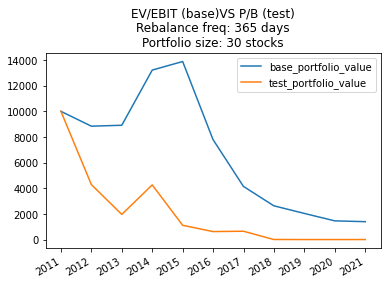

In [23]:
BackTester.plot_backtest(btr_30)

In [ ]:
BackTester.plot_backtest(btr_90)

In [ ]:
BackTester.plot_backtest(btr_180)

In [ ]:
BackTester.plot_backtest(btr_365)

In [ ]:
BackTester.plot_backtest(btr_730)

In [ ]:
BackTester.plot_backtest(btr_1825)